In [36]:
from ezfit import FitPDF, Contribution
from ezpdf import plot_PDF
from pathlib import Path


data_file = Path("data/gr/SBa200.gr")

AlOOH = Contribution("d4Al2O3", "sphericalCF", "Al2O3")

fit = FitPDF(data_file, contributions=[AlOOH])


fit.update_recipe()
fit.shared_param("d4Al2O3", "Al", "Biso")
fit.shared_param("d4Al2O3", "O", "Biso")


fit.run_fit()

Some quantities invalid due to missing profile uncertaintyelta2, d4Al2O3_a, d4Al2O3_b, d4Al2O3_c, d4Al2O3_beta, d4Al2O3_Al1_Biso, d4Al2O3_O1_Biso
Overall (Chi2 and Reduced Chi2 invalid)
------------------------------------------------------------------------------
Residual       1000044.07586424
Contributions  44.07586424
Restraints     1000000.00000000
Chi2           44.07586424
Reduced Chi2   0.02108893
Rw             0.28624285

Variables (Uncertainties invalid)
------------------------------------------------------------------------------
d4Al2O3_Al1_Biso  5.80464714e-01 +/- 1.87125518e-01
d4Al2O3_O1_Biso   5.06748609e-01 +/- 2.99046169e-01
d4Al2O3_a         1.20775265e+01 +/- 3.43978066e-02
d4Al2O3_b         1.11702814e+01 +/- 3.45410600e-02
d4Al2O3_beta      1.81987272e+00 +/- 7.80641528e-03
d4Al2O3_c         1.13677190e+01 +/- 4.34125046e-02
d4Al2O3_delta2    2.75008843e+00 +/- 6.25752719e-01
d4Al2O3_psize     1.12312927e+02 +/- 6.48786743e+01
d4Al2O3_scale     2.55818692e-01 +/

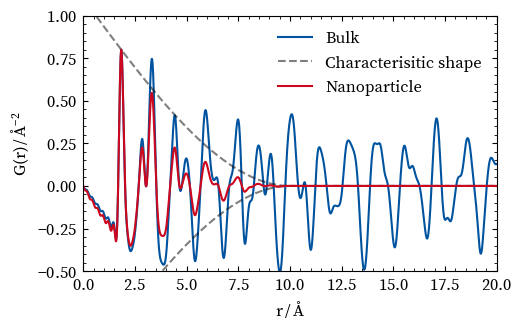

In [37]:
from ezplot import plot_defaults
import matplotlib.pyplot as plt
import diffpy.srfit.pdf.characteristicfunctions as CF


fit.recipe.d4Al2O3_psize = 100
r, _, gcalc, _, _, _ = get_gr(fit.recipe)

fig, gs = plot_defaults(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.plot(r, 0.8 * gcalc/gcalc.max(), label="Bulk")

fit.recipe.d4Al2O3_psize = 10
r, _, gcalc, _, _, _ = get_gr(fit.recipe)



ax.plot(r, 1.1 * CF.sphericalCF(r, 10), c="k", alpha=0.5, linestyle="--")
ax.plot(r, - 1.1 * CF.sphericalCF(r, 10), c="k", alpha=0.5, linestyle="--", label="Characterisitic shape")
ax.plot(r, 0.8 * gcalc/gcalc.max(), label="Nanoparticle")
ax.set_xlim(0, 20)
ax.set_ylim(-0.5, 1)
ax.set_ylabel("G(r)$\,/\,\mathrm{\AA}^{-2}$")
ax.set_xlabel("r$\,/\,\mathrm{\AA}$")
ax.legend(frameon=False)
plt.savefig("psize.pdf")

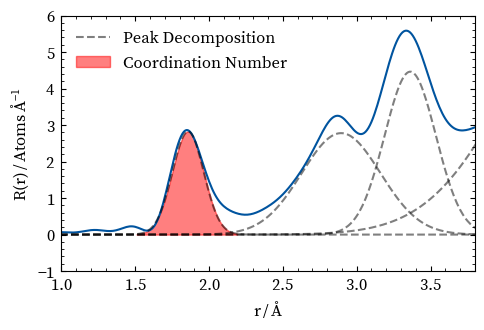

In [200]:
from ezplot import plot_defaults
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import diffpy.srfit.pdf.characteristicfunctions as CF

import numpy as np


def line(x, a, b):
    return a * x + b

fit.recipe.d4Al2O3_psize = 100
r, _, gcalc, _, _, _ = get_gr(fit.recipe)

fig, gs = plot_defaults(1, 1)
ax = fig.add_subplot(gs[0, 0])


fit.recipe.d4Al2O3_psize = 10
r, _, gcalc, _, _, _ = get_gr(fit.recipe)

popt, pcov = curve_fit(line, r[r < 1.75], gcalc[r < 1.75]) 

def gaus(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))
Rr = gcalc/gcalc.max() * r - 4 * np.pi * r**2 * 0.3 * popt[1]

ax.plot(r, Rr)
ax.set_xlim(1, 3.8)
ax.set_ylim(-1, 6)
ax.set_ylabel("R(r)$\,/\,\mathrm{Atoms}\,\mathrm{\AA}^{-1}$")
ax.set_xlabel("r$\,/\,\mathrm{\AA}$")

def fourgaus(x, a1, x1, sigma1, a2, x2, sigma2, a3, x3, sigma3, a4, x4, sigma4):
    return gaus(x, a1, x1, sigma1) + gaus(x, a2, x2, sigma2) + gaus(x, a3, x3, sigma3) + gaus(x, a4, x4, sigma4)




gpopt, _ = curve_fit(fourgaus, r[(r > 1.5) & (r < 4.6)], Rr[(r > 1.5) & (r < 4.6)], p0=[3, 1.85, 0.13, 3, 2.86, 0.23, 5.4, 3.35, 0.2, 0.5, 4.5, 1])

#ax.plot(r, fourgaus(r, *gpopt), c="k", alpha=0.5, linestyle="--", label=r"Atomic Density $\rho_0$")
gpopt[0] += 0.06
gpopt[1] -= 0.01
gpopt[2] -= 0.02
gpopt[4] += 0.05
ax.plot(r, gaus(r, *gpopt[:3]), c="k", alpha=0.5, linestyle="--", label="Peak Decomposition")
ax.plot(r, gaus(r, *gpopt[3:6]), c="k", alpha=0.5, linestyle="--")
ax.plot(r, gaus(r, *gpopt[6:9]), c="k", alpha=0.5, linestyle="--")
ax.plot(r, gaus(r, *gpopt[9:]), c="k", alpha=0.5, linestyle="--")

rl = r[(r > 1.5) & (r < 2.2)]
ax.fill_between(rl, gaus(rl, *gpopt[:3]), 0, alpha=0.5, color="red", label=r"Coordination Number")

rlim = r[(r > 3.1) & (r < 3.8)]
#ax.fill_between(rlim, line(rlim, *popt) + 0.05, 0.8 * gcalc[(r > 3.1) & (r < 3.8)]/gcalc.max(), alpha=0.5, color="k", label=r"Peak Area")
ax.legend(frameon=False)
plt.savefig("density.pdf")

In [3]:
import re 

def get_gr(recipe):
    """
    g.t the gr of a recipe and for each phase contribution
    returns:
    - r: list of floats
    - gobs: list of floats
    - gcalc: list of floats
    - gdiff: list of floats
    - baseline: float
    - gr_composition: dict of list of floats
    """
    def remove_consecutive_duplicates(string, char):
        indices = [m.start() for m in re.finditer(char * 2, string)]
        if indices:
            for i in indices:
                string = string[:i] + string[i+1:]
            return remove_consecutive_duplicates(string, char)
        else:
            return string

    equation = recipe.PDF.getEquation()
    for char in [r'\)', r'\(']:
        equation = (remove_consecutive_duplicates(equation, char))
        
    prof = recipe._contributions['PDF'].profile
    r = prof.x
    gobs = prof.y
    gcalc = recipe._contributions['PDF'].evaluate()
    baseline = 1.10 * gobs.min()
    gdiff = gobs - gcalc

    gr_composition = {}
    for eq in equation.split(' + '):
        gr = recipe.PDF.evaluateEquation(eq[1:])
        gr_composition[eq[1:]] = gr

    return r, gobs, gcalc, gdiff, baseline, gr_composition

In [ ]:
fit.res.saveResults("200.res")

-2.01384 1.92042 y_min, y_max
-1.0 1.0 y_norm.min(), y_norm.max()
-2.01384 1.92042 y_min, y_max
-0.9162818718701613 0.96659407887177 y_norm.min(), y_norm.max()
-2.01384 1.92042 y_min, y_max
-0.16336150699209628 0.25019819221036266 y_norm.min(), y_norm.max()
-2.01384 1.92042 y_min, y_max
-1.102374525323695 -1.102374525323695 y_norm.min(), y_norm.max()
-2.01384 1.92042 y_min, y_max
-1.102374525323695 -1.102374525323695 y_norm.min(), y_norm.max()
-2.01384 1.92042 y_min, y_max
0.023745253236949315 0.023745253236949315 y_norm.min(), y_norm.max()
-10 10 y_min, y_max
-1.0 1.0 y_norm.min(), y_norm.max()
[-1.  1.]


(<Figure size 590.551x364.981 with 1 Axes>,
 <AxesSubplot:xlabel='$r\\,/\\,\\mathrm{\\AA}$', ylabel='$G(r)\\,/\\,\\mathrm{\\AA}^{-2}$'>)

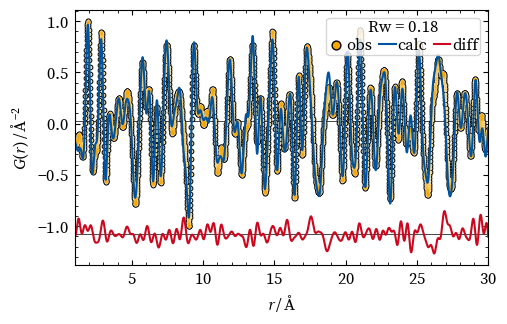

In [6]:
plot_PDF(fit, fit.recipe, fit.res)